# Plotting Drake Passage Transport in ACCESS-OM3

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [ ]:
#The following cell must be in all notebooks!

In [ ]:
#parameters

### USER EDIT start
esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

# needed for mkmd START 
project_root = f"/g/data/tm70/{os.environ['USER']}/access-om3-paper-1"
notebooks_dir = os.path.join(project_root, "notebooks")
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())
os.mkdir(project_root+'/mkmd/')
from mkfigs_configdoc import mkmd
## example usage: 
## mkmd("Comparing overturning circulation in ACCESS-OM3 with ACCESS-OM2","Contour are in Sv etc...",os.path.basename(os.path.dirname(esm_file)),os.path.basename(session_path)[:-6]+'.png',project_root+'/')
# needed for mkmd STOP

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output/2/


In [1]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime


In [2]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Load ACCESS-OM3 data from ESM datastore

In [3]:
#datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [4]:
umo_2d = datastore.search(variable="umo_2d").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)

## Load ACCESS-OM2 data from ACCESS-NRI Catalog

In [5]:
catalog = intake.cat.access_nri

In [6]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='tx_trans_int_z',frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
tx_trans_int_z=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


## Just to show the latitude I've picked ...

(-80.0, -40.0)

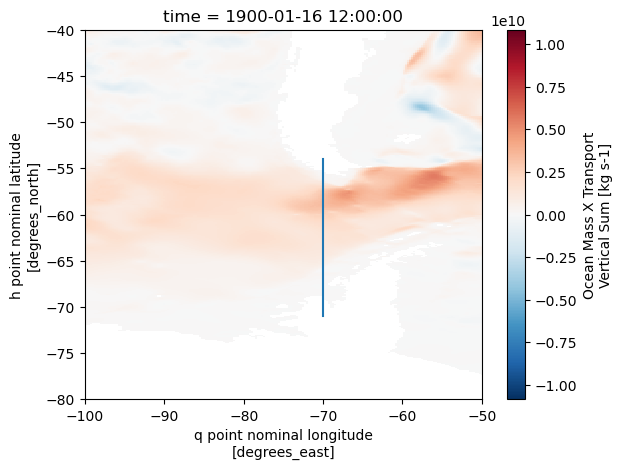

In [7]:
umo_2d["umo_2d"].isel(time=0).plot()
plt.plot([-70,-70],[-71,-54])
plt.xlim([-100,-50])
plt.ylim([-80,-40])

## Timeseries of DP Transport at -70°

In [8]:
DP_Trans_OM3 = umo_2d["umo_2d"].sel(xq=-70,method='nearest').sel(yh=slice(-71,-54)).sum("yh").load() / 1025 / 1e6

In [9]:
DP_Trans_OM2 = tx_trans_int_z["tx_trans_int_z"].sel(xu_ocean=-70,method='nearest').sel(yt_ocean=slice(-71,-54)).sum("yt_ocean").sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).load() / 1036 / 1e6

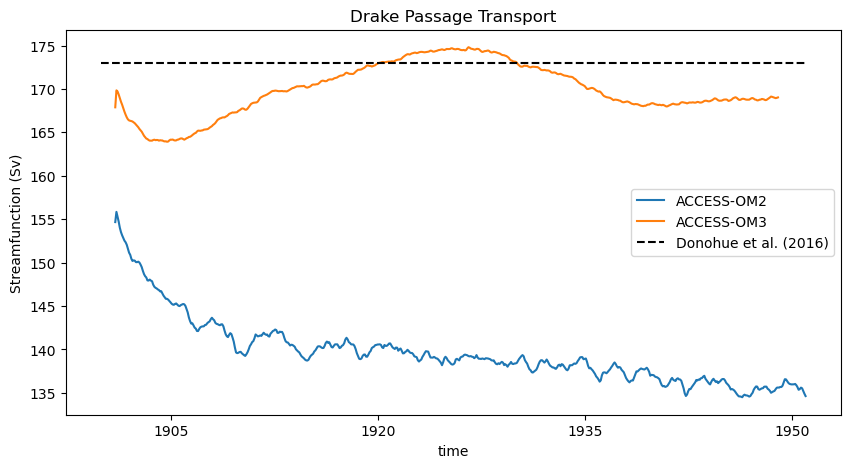

In [10]:
plt.figure(figsize=(10, 5)) 

DP_Trans_OM2.rolling(time=12).mean().plot(label='ACCESS-OM2')
DP_Trans_OM3.rolling(time=12).mean().plot(label='ACCESS-OM3')

plt.plot([cftime.datetime(1900, 1, 1), cftime.datetime(1950, 12, 31)], [173, 173],
           'k--', label="Donohue et al. (2016)")

plt.ylabel('Streamfunction (Sv)')
plt.title('Drake Passage Transport')
plt.legend()

In [11]:
client.close()